# Welcome to BlazingSQL Notebooks!

BlazingSQL Notebooks is a fully managed, high-performance JupyterLab environment. 

**No setup required.** You just login and start writing code, immediately.

Every Notebooks environment has:   
- An attached CUDA GPU
- Pre-Installed GPU Data Science Packages ([BlazingSQL](https://github.com/BlazingDB/blazingsql), [RAPIDS](https://github.com/rapidsai), [Dask](https://github.com/dask), and many more)

Start running GPU-accelerated code below!

## The DataFrame
The RAPIDS ecosystem is built on the concept of a shared GPU DataFrame, built on [Apache Arrow](http://arrow.apache.org/), between all of the different libraries and packages.

There are two libraries specific to data manipulation:
- **BlazingSQL**:  SQL commands on a GPU DataFrame
- **cuDF**: pandas-like commands on a GPU DataFrame

### BlazingSQL (BSQL) 
[GitHub](https://github.com/BlazingDB/blazingsql) | [Intro Notebook](intro_notebooks/blazingcontext.ipynb)

BlazingSQL is a distributed SQL engine built on top of cuDF. Easily run SQL on files and DataFrames.

We start with a BlazingContext, which acts like a session of the SQL engine.

In [1]:
from blazingsql import BlazingContext
bc = BlazingContext()

BlazingContext ready


With `.create_table('table_name', 'file_path')` you can create tables from many formats. Here we infer the schema from a CSV file.

In [2]:
import os
bc.create_table('taxi', f'{os.getcwd()}/data/sample_taxi.csv', header=0)

Now, we can run a SQL query directly on that CSV file with `.sql()`.

In [3]:
bc.sql('SELECT * FROM taxi')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_x,pickup_y,dropoff_x,dropoff_y
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,1,N,1,12.0,1.0,0.5,3.25,0.00,0.3,17.05,-8236962.878,66.693057,-8234835.381,66.694056
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,1,N,1,14.5,0.5,0.5,2.00,0.00,0.3,17.80,-8237825.768,66.642117,-8237020.631,66.710783
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,1,N,2,9.5,0.5,0.5,0.00,0.00,0.3,10.80,-8233561.431,66.796854,-8232278.987,66.839490
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,1,N,2,3.5,0.5,0.5,0.00,0.00,0.3,4.80,-8238653.836,66.621592,-8238123.872,66.633735
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,1,N,2,15.0,0.5,0.5,0.00,0.00,0.3,16.30,-8234433.662,66.717321,-8238107.735,66.678369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743655,1,2015-01-28 11:11:43,2015-01-28 11:29:03,1,2.60,1,N,1,12.5,0.0,0.5,1.50,0.00,0.3,14.80,-8233738.934,66.725941,-8236360.724,66.662901
743656,1,2015-01-28 11:11:43,2015-01-28 11:24:39,1,2.50,1,N,2,12.0,0.0,0.5,0.00,0.00,0.3,12.80,-8236326.753,66.619617,-8239263.633,66.604966
743657,1,2015-01-28 11:11:43,2015-01-28 11:19:05,1,0.50,1,N,1,6.0,0.0,0.5,1.70,0.00,0.3,8.50,-8237036.767,66.674845,-8236477.079,66.687925
743658,1,2015-01-28 11:11:43,2015-01-28 11:35:15,1,9.10,1,N,1,28.5,0.0,0.5,6.92,5.33,0.3,41.55,-8223703.602,66.740356,-8233243.793,66.732021


Learn more about [creating](intro_notebooks/create_tables.ipynb) and [querying](intro_notebooks/query_tables.ipynb) BlazingSQL tables, or the [BlazingContext API](intro_notebooks/blazingcontext.ipynb).

BlazingSQL returns each query's results as a cuDF DataFrame, making for easy handoff to GPU or non-GPU solutions.

In [4]:
type(bc.sql('select * from taxi'))

cudf.core.dataframe.DataFrame

### cuDF
[GitHub](https://github.com/rapidsai/cudf) | [Intro Notebook](intro_notebooks/the_dataframe.ipynb)

cuDF is a GPU DataFrame Library similar to pandas.

In [24]:
import cudf
s = cudf.Series([1,2,3,None,4])
s

0       1
1       2
2       3
3    null
4       4
dtype: int64

You can also make a GPU DataFrame from a SQL statement.

In [ ]:
gdf = bc.sql('select * from taxi where trip_distance < 10')

Utilize DataFrame methods like `.head()` or `.tail()`.

In [25]:
gdf.tail(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_x,pickup_y,dropoff_x,dropoff_y
731204,1,2015-01-28 11:11:43,2015-01-28 11:35:15,1,9.1,1,N,1,28.5,0.0,0.5,6.92,5.33,0.3,41.55,-8223703.602,66.740356,-8233243.793,66.732021
731205,1,2015-01-28 11:11:44,2015-01-28 11:21:56,1,1.5,1,N,2,8.5,0.0,0.5,0.00,0.00,0.3,9.30,-8232741.006,66.735944,-8234567.002,66.711625


Tell me about the taxi rides under 10 miles.

In [7]:
gdf.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_x,pickup_y,dropoff_x,dropoff_y
count,731206.000000,731206.000000,731206.000000,731206.000000,731206.000000,731206.000000,731206.000000,731206.000000,731206.000000,731206.000000,731206.000000,731206.000000,7.312060e+05,731206.000000,7.312060e+05,731206.000000
mean,1.525141,1.683695,2.110928,1.008933,1.388211,10.023943,0.315833,0.499003,1.300654,0.085120,0.283192,12.523875,-8.235333e+06,66.699610,-8.235131e+06,66.700190
std,0.499368,1.342609,1.735554,0.509256,0.497665,5.848819,0.366803,0.025225,1.621419,0.714763,0.068992,7.037828,2.397015e+03,0.043212,2.541876e+03,0.048194
min,1.000000,0.000000,0.000000,1.000000,1.000000,-52.000000,-1.000000,-0.500000,-81.000000,-5.330000,0.000000,-116.220000,-8.254080e+06,66.555036,-8.254078e+06,66.555036
25%,1.000000,1.000000,0.970000,1.000000,1.000000,6.000000,0.000000,0.500000,0.000000,0.000000,0.300000,8.000000,-8.236762e+06,66.670578,-8.236706e+06,66.669526
50%,2.000000,1.000000,1.570000,1.000000,1.000000,8.500000,0.000000,0.500000,1.000000,0.000000,0.300000,10.800000,-8.235663e+06,66.702066,-8.235514e+06,66.702750
75%,2.000000,2.000000,2.620000,1.000000,2.000000,12.000000,0.500000,0.500000,2.000000,0.000000,0.300000,14.800000,-8.234246e+06,66.728564,-8.233885e+06,66.730946
max,2.000000,9.000000,9.990000,99.000000,4.000000,900.000000,7.000000,0.500000,200.000000,117.820000,0.300000,900.300000,-8.210362e+06,66.870206,-8.210008e+06,66.870153


You can also filter GPU DataFrames similarly to pandas DataFrames.

In [9]:
gdf.loc[(gdf['passenger_count'] > 1) & (gdf['trip_distance'] < 10)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_x,pickup_y,dropoff_x,dropoff_y
7,1,2015-01-10 20:33:39,2015-01-10 20:42:20,3,0.80,1,N,1,7.0,0.5,0.5,1.66,0.00,0.3,9.96,-8237938.725,66.661609,-8237086.877,66.646218
8,1,2015-01-10 20:33:40,2015-01-10 20:40:44,2,0.90,1,N,1,6.5,0.5,0.5,1.55,0.00,0.3,9.35,-8236037.990,66.728196,-8236074.511,66.711286
15,2,2015-01-15 19:05:40,2015-01-15 19:21:00,5,2.83,1,N,2,12.5,1.0,0.5,0.00,0.00,0.3,14.30,-8234158.488,66.701202,-8232646.734,66.765456
16,2,2015-01-15 19:05:40,2015-01-15 19:28:18,5,8.33,1,N,1,26.0,1.0,0.5,8.08,5.33,0.3,41.21,-8222398.228,66.731412,-8232378.355,66.763336
18,2,2015-01-15 19:05:41,2015-01-15 19:20:22,2,7.13,1,N,1,21.5,1.0,0.5,4.50,0.00,0.3,27.80,-8223667.082,66.740138,-8232340.986,66.630986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731180,2,2015-01-26 08:56:35,2015-01-26 09:10:50,5,1.21,1,N,1,10.0,0.0,0.5,2.00,0.00,0.3,12.80,-8235459.617,66.712511,-8234224.735,66.719906
731183,2,2015-01-15 22:26:52,2015-01-15 22:40:52,5,3.92,1,N,1,14.5,0.5,0.5,3.75,0.00,0.3,19.55,-8236620.611,66.642372,-8235840.952,66.564779
731186,1,2015-01-07 23:07:01,2015-01-07 23:13:12,4,1.00,1,N,1,6.0,0.5,0.5,1.45,0.00,0.3,8.75,-8238085.653,66.656741,-8236739.512,66.648231
731193,1,2015-01-28 11:11:40,2015-01-28 11:19:31,2,1.10,1,N,1,7.0,0.0,0.5,1.56,0.00,0.3,9.36,-8235440.083,66.683297,-8236826.141,66.664516


To ensure interoperability, you can also easily convert from cuDF to a pandas DataFrame with `.to_pandas()`. This grants you access to all of pandas methods, in this example, `.sample()`.

In [8]:
gdf.to_pandas().sample(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_x,pickup_y,dropoff_x,dropoff_y
634130,1,2015-01-20 12:45:05,2015-01-20 13:15:13,1,4.90,1,N,3,2.5,0.0,0.5,0.00,5.33,0.3,8.63,-8234728.370,66.714758,-8222968.957,66.737628
370910,2,2015-01-01 11:17:16,2015-01-01 11:20:44,1,0.58,1,N,1,4.5,0.0,0.5,0.90,0.00,0.3,6.20,-8236545.022,66.658927,-8236906.824,66.676062
121355,2,2015-01-23 19:00:20,2015-01-23 19:30:52,3,3.96,1,N,1,20.0,1.0,0.5,4.36,0.00,0.3,26.16,-8233437.433,66.749767,-8237727.249,66.661128


Learn more about [BlazingSQL + cuDF](intro_notebooks/the_dataframe.ipynb).

## Data Visualization
GPU DataFrames easily plug into current and GPU accelerated visualization.


### Matplotlib
Recalling the `.to_pandas()` method, we can convert a GPU DataFrame into a pandas DataFrame and hand off to Matplotlib or other python visualization packages that support Pand

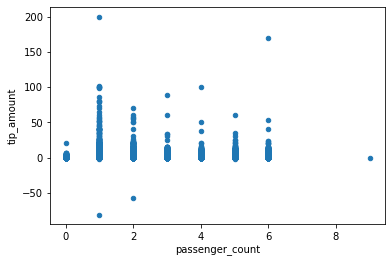

In [10]:
df = bc.sql('SELECT passenger_count, tip_amount FROM taxi').to_pandas()

df.plot(kind='scatter', 
        x='passenger_count', 
        y='tip_amount')

### Datashader
[Datashader](https://datashader.org/) is one of the first visualization tools to integrate GPU DataFrames.

In [ ]:
import datashader as ds
from colorcet import fire

We execute and pass a query as a GPU DataFrame to datashader to render taxi dropoff locations.

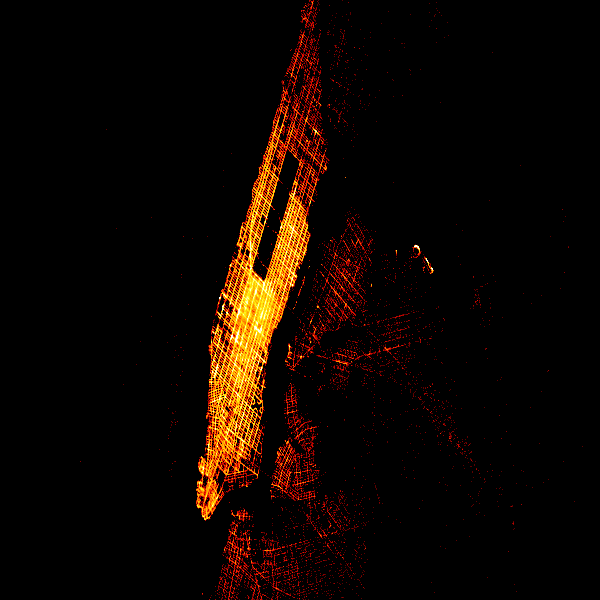

In [27]:
nyc = ds.Canvas().points(bc.sql('SELECT dropoff_x, dropoff_y FROM taxi'), 'dropoff_x', 'dropoff_y')

ds.transfer_functions.set_background(ds.transfer_functions.shade(nyc, cmap=fire), "black")

## Machine Learning
### cuML 
[GitHub](https://github.com/rapidsai/cuml) | [Intro Notebook](intro_notebooks/cuml.ipynb)

cuML is a GPU-accelerated machine learning library similar to scikit-learn but made to run on the GPU DataFrame.

Let's predict fare amount of the `taxi` table we've been querying with a linear regression model.

In [28]:
%%time
from cuml import LinearRegression
from cuml.preprocessing.model_selection import train_test_split

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 15 µs


Pull feature (X) and target (y) values

In [44]:
X = bc.sql('SELECT trip_distance, tolls_amount, pickup_x, pickup_y, dropoff_x, dropoff_y FROM taxi')
y = bc.sql('SELECT fare_amount FROM taxi')['fare_amount']

Split data into train and test sets (80:20)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

Run a Linear Regression Model.

In [46]:
%%time
# call Linear Regression model
lr = LinearRegression()

# train the model
lr.fit(X_train, y_train)

# make predictions for test X values
y_pred = lr.predict(X_test)

CPU times: user 19.8 ms, sys: 8.04 ms, total: 27.9 ms
Wall time: 27.1 ms


Test the predicted values with sklearn r2_score.

In [48]:
from sklearn.metrics import r2_score
r2_score(y_true=y_test.to_pandas(), y_pred=y_pred.to_pandas())

0.2866366127408204

## That is the Quick Tour!
There are in fact many more packages that are integrating the GPU DataFrame, and therefore providing interoperability with the rest of the stack.

Some of those not mentioned here are:
- **cuGraph**: a graph analytics library similar to NetworkX
- **cuSignal**: a signal analytics library similar to SciPy Signal
- **CLX**: a collection of cyber security use cases with the RAPIDS stack

[Continue to The DataFrame introductory Notebook](intro_notebooks/the_dataframe.ipynb)